# Load package and import data 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 股票数据

In [2]:
df_price=pd.read_csv('../data/论文阅读题_行情数据.csv')

In [3]:
#drop volume and amount 
df_price=df_price[['Code','Date','PreClose','Open','Close']]
#set date as index which type is datetime
df_price=df_price.set_index('Date')
df_price.index=pd.to_datetime(df_price.index)
#we drop data if the open price==0
df_price=df_price[df_price.Open!=0]

###  Return



CTO : daily over night return; 
DR : daily return; CR: compounded return;

$$
CTO_{i,t}=\frac{Open_{i,t}-preClose_{i,t}}{preClose_{i,t}}$
\\
DR_{i,t} = \frac{Close_{i,t}}{Close_{i,t-1}}-1
\\
CR_{t,t+n} = \Pi _t^{t+n}(DR_{i,t}+1)=\frac{Close_{i,t+n}}{Close_{i,t+n-1}}\frac{Close_{i,t+n-1}}{Close_{i,t+n-2}}...\frac{Close_{i,t+1}}{Close_{i,t}}=\frac{Close_{i,t+n}}{Close_{i,t}}
$$

We are going to calculate weekly total return and weekly overnight return. 

(1) Weekly total return is the compounded daily return over that week. 

(2) Weekly overnight return is average daily overnight return during that week , multiply 5. 

#### Weekly_Total_Return (WTR)

In [4]:
 #frequencey: day->week (last Wednesday to this Tuesday)
df_wtr=pd.DataFrame(df_price.groupby('Code').Close.resample('W-TUE').last())
#calculate weekly total return : close_last_week/close_this_week-1
df_wtr['WTR']=df_wtr.Close/df_wtr.groupby(level=0).Close.shift(1)-1 
df_wtr.drop('Close',axis=1,inplace=True) 
display(df_wtr.head())

WTR
Code      Date                
000001.SZ 2008-01-08       NaN
          2008-01-15  0.040604
          2008-01-22 -0.148227
          2008-01-29 -0.002235
          2008-02-05  0.044233

#### Weekly_Overnight_Return(WOR)

In [5]:
#calculate CTO=Open\PreClose-1
df_wor=df_price[['Code','PreClose','Open']]
df_wor['CTO']=(df_wor['Open']-df_wor['PreClose'])/df_wor['PreClose']
df_wor=df_wor[['Code','CTO']]

In [6]:
#以礼拜二为分界点，划分每周。每只股票每周的隔夜收益率平均数*5
#df_wor.groupby('Code').CTO.resample('W-TUE').mean() 结果一样，用grouper 速度稍微快一点
df_wor=pd.DataFrame(df_wor.groupby(['Code', pd.Grouper(level=0, freq='W-TUE')])['CTO'].mean()*5)
df_wor.rename(columns={'CTO':'WOR'},inplace=True)

In [7]:
#merge weekly overnight return and weekly total return 
df_m=pd.concat([df_wor,df_wtr], axis=1)
df_m.reset_index(inplace=True)
display(df_m.head())

,Code,Date,WOR,WTR
0,000001.SZ,2008-01-08,0.000705,NaN
1,000001.SZ,2008-01-15,0.004541,0.040604
2,000001.SZ,2008-01-22,-0.058696,-0.148227
3,000001.SZ,2008-01-29,0.032049,-0.002235
4,000001.SZ,2008-02-05,0.068942,0.044233


### Volatility (df_return_vol)

Volatility is the standard deviation of the stock monthly return over months t-12 to thourgh t-2.

In [8]:
#calculate monthly return 
df_price_m=pd.DataFrame(df_price.groupby(['Code', pd.Grouper(level=0, freq='BM')])['Close'].last())
df_price_m['M_Ret']=df_price_m.Close/df_price_m.groupby('Code').Close.shift(1)-1 #calculate monthly return 

# rolling window 12, 计算前十个收益率的标准差
def volatility(x):
    return x[:11].std()
    
df_price_m['Vol']=(df_price_m.M_Ret.groupby(level=0).rolling(13).apply(volatility,raw=True)).values
df_return_vol=df_price_m[['Vol']].dropna().reset_index()

#frequency: monthly->weekly
df_return_vol=df_return_vol.set_index('Date').groupby('Code').resample('W-TUE').bfill()
df_return_vol=df_return_vol.drop('Code',axis=1).reset_index()
display(df_return_vol.head())

,Code,Date,Vol
0,000001.SZ,2009-03-03,0.184922
1,000001.SZ,2009-03-10,0.184922
2,000001.SZ,2009-03-17,0.184922
3,000001.SZ,2009-03-24,0.184922
4,000001.SZ,2009-03-31,0.184922


### Size (df_size_m)

Size is defined as market value of the firm as of the end of the prior fiscal quater

In [9]:
#read data
df_share=pd.read_csv('../data/论文阅读题_股本数据.csv')
df_share.drop('TotalShr',axis=1,inplace=True)
df_share=df_share.sort_values(by=['Code','Date']).reset_index(drop=True)
df_share=df_share.set_index('Date')
df_share.index=pd.to_datetime(df_share.index)

In [10]:
#price and share at the end of quarter , 
df_share_q=df_share[df_share.index.is_quarter_end] #share 数据齐全，可以直接用index搜索，但是股票价格不是每天都有
df_price_q=pd.DataFrame(df_price.groupby(['Code', pd.Grouper(level=0, freq='BQ')])['Close'].last())

In [11]:
#merge df of share and price to calculate market value
a=df_price_q.reset_index()
b=df_share_q.reset_index()
df_size=a.merge(b)
df_size['Size']=df_size.OutStdShr*df_size.Close
df_size.head()

,Code,Date,Close,OutStdShr,Size
0,000001.SZ,2008-03-31,28.20,175682.0549,4.954234e+06
1,000001.SZ,2008-06-30,19.33,204652.0536,3.955924e+06
2,000001.SZ,2008-09-30,14.99,214200.4409,3.210865e+06
3,000001.SZ,2008-12-31,9.46,278460.5731,2.634237e+06
4,000001.SZ,2009-03-31,15.94,278460.5731,4.438662e+06


需要注意的是，这里用了这个季度末的价格和股票数计算的市场价值，size需要用上个季度末的数据，所以在将季度数据变成周数据时候，用ffill()

In [12]:
#frequency: monthly->weekly
df_size=df_size.set_index('Date').groupby('Code').resample('W-TUE').ffill()
df_size=df_size.drop('Code',axis=1).reset_index()

df_size_m=df_size[['Code','Date','Size']]
df_size_m.head()

,Code,Date,Size
0,000001.SZ,2008-04-01,4.954234e+06
1,000001.SZ,2008-04-08,4.954234e+06
2,000001.SZ,2008-04-15,4.954234e+06
3,000001.SZ,2008-04-22,4.954234e+06
4,000001.SZ,2008-04-29,4.954234e+06


### Profitability (df_prof)

In [13]:
df_e=pd.read_csv('../data/论文阅读题_利润数据.csv')
df_e.drop('AnnDate',axis=1,inplace=True)

####  TTM

计算TTM，按照半年划分，

上半年：TTM= 去年的年报数据，

下半年：TTM= 去年的年报-去年6月份中报+今年6月份中报

In [14]:
#导入数据
df_e=df_e.sort_values(by=['Code','RptPeriod']).reset_index(drop=True)
df_e.set_index('RptPeriod',inplace=True)
df_e.index = pd.to_datetime(df_e.index)
df_e=df_e[(df_e.index.quarter==2) |( df_e.index.quarter==4)] #取年报和中报

In [15]:
def cal_TTM(x): 
    #上半年half1用去年年报数据
    x['Half1']=x.Earnings.shift(1) 
    #下半年half2去年的年报-去年6月份中报+今年6月份中报
    x['Half2']=x.Earnings.shift(1)+x.Earnings.shift(2)-x.Earnings.shift(3) 
    #如果是上半年，保留half1
    half1=x[x.index.quarter==2].drop('Half2',axis=1).rename(columns={'Half1':'TTM'})
    #如果是下半年，保留half2
    half2=x[x.index.quarter==4].drop('Half1',axis=1).rename(columns={'Half2':'TTM'})
    #合并数据
    TTM=pd.concat([half1,half2]).sort_index().fillna(method='ffill')
    return TTM
df_TTM=df_e.groupby('Code').apply(cal_TTM)
#slow

In [16]:
df_TTM=df_TTM[['Code','TTM']]
df_TTM=df_TTM.groupby('Code').resample('Q').bfill() #halfyear-quater
df_TTM=df_TTM.drop('Code',axis=1).dropna().reset_index()

In [17]:
df_TTM.rename(columns={'RptPeriod':'Date'},inplace=True)
display(df_TTM.head())
#表示在2008-03-31这个季度使用的TTM为2.6e+09

,Code,Date,TTM
0,000001.SZ,2008-03-31,2.607545e+09
1,000001.SZ,2008-06-30,2.607545e+09
2,000001.SZ,2008-09-30,2.607545e+09
3,000001.SZ,2008-12-31,2.607545e+09
4,000001.SZ,2009-03-31,6.239410e+08


#### Profitablity

In [18]:
#read data 
df_bkv=pd.read_csv('../data/论文阅读题_权益数据.csv')
df_bkv.drop('AnnDate',axis=1,inplace=True)
df_bkv.rename(columns={'RptPeriod':'Date'},inplace=True)
df_bkv=df_bkv.sort_values(by=['Code','Date']).reset_index(drop=True)
df_bkv=df_bkv.set_index('Date')
df_bkv.index=pd.to_datetime(df_bkv.index)
df_bkv.index=df_bkv.index+pd.DateOffset(months=3)


In [19]:

#删除bkv为0的记录，bkv之后要做分母
df_bkv=df_bkv[df_bkv.BookValue!=0].reset_index()

#合并TTM，计算profitability
df_prof=df_TTM.merge(df_bkv,on=['Date','Code'])
df_prof['Profitability']=df_prof.TTM/df_prof.BookValue
df_prof_m=df_prof[['Code','Date','Profitability']]

#frequency->weekly
df_prof_m=df_prof_m.set_index('Date').groupby('Code').resample('W-TUE').bfill() #ffill:bookvalue at the begining of the quater is the bkv of last quater
df_prof_m=df_prof_m.drop('Code',axis=1).reset_index()
display(df_prof_m.head())


,Code,Date,Profitability
0,000001.SZ,2008-04-01,0.185704
1,000001.SZ,2008-04-08,0.185704
2,000001.SZ,2008-04-15,0.185704
3,000001.SZ,2008-04-22,0.185704
4,000001.SZ,2008-04-29,0.185704


### Earning to Price Ratio  (df_EPR)

EPR (Earning to price ratio) is TTM divided by the close price of the quater.

In [20]:
#calculyae EPR
df_EPR=df_TTM.merge(df_price_q,on=['Code','Date'])
df_EPR['EPR']=df_EPR.TTM/df_EPR.Close
display(df_EPR.head())

,Code,Date,TTM,Close,EPR
0,000001.SZ,2008-03-31,2.607545e+09,28.20,9.246613e+07
1,000001.SZ,2008-06-30,2.607545e+09,19.33,1.348963e+08
2,000001.SZ,2008-09-30,2.607545e+09,14.99,1.739523e+08
3,000001.SZ,2008-12-31,2.607545e+09,9.46,2.756390e+08
4,000001.SZ,2009-03-31,6.239410e+08,15.94,3.914310e+07


In [21]:
df_EPR_m=df_EPR[['Code','Date','EPR']]

#frequency->weekly
df_EPR_m=df_EPR_m.set_index('Date').groupby('Code').resample('W-TUE').bfill()
df_EPR_m=df_EPR_m.drop('Code',axis=1).reset_index()
df_EPR_m.head()

,Code,Date,EPR
0,000001.SZ,2008-04-01,1.348963e+08
1,000001.SZ,2008-04-08,1.348963e+08
2,000001.SZ,2008-04-15,1.348963e+08
3,000001.SZ,2008-04-22,1.348963e+08
4,000001.SZ,2008-04-29,1.348963e+08


## Merge dataframes

In [22]:
df_list=[df_return_vol,df_size_m,df_prof_m,df_EPR_m]
#frequence: quater 
df_total=df_m.merge(df_return_vol).merge(df_size_m).merge(df_prof_m).merge(df_EPR_m)
display(df_total.head())

,Code,Date,WOR,WTR,Vol,Size,Profitability,EPR
0,000001.SZ,2009-03-03,-0.185929,-0.098732,0.184922,2.634237e+06,0.038043,3.914310e+07
1,000001.SZ,2009-03-10,-0.010132,0.099186,0.184922,2.634237e+06,0.038043,3.914310e+07
2,000001.SZ,2009-03-17,0.026351,0.070034,0.184922,2.634237e+06,0.038043,3.914310e+07
3,000001.SZ,2009-03-24,-0.008496,-0.013845,0.184922,2.634237e+06,0.038043,3.914310e+07
4,000001.SZ,2009-03-31,-0.025068,0.017230,0.184922,4.438662e+06,0.038043,3.914310e+07


In [23]:
#分组
def factor(x):
    return pd.qcut(x.WOR,10,duplicates='drop',labels=False) #按照WOR分10组，

df_total.sort_values(by=['Date','WOR'],inplace=True)
group_num=df_total.groupby('Date').apply(factor).values  #每周对股票按照WOR进行分组
df_total['Group_Num']=group_num



In [24]:
#计算每周每组的平均收益率
df_price_weekly_group_mean=df_total.groupby(['Date','Group_Num']).mean()
#0 表示该周CTO最低的一组， 9表示最高
df_price_weekly_group_mean.reset_index(drop=False,inplace=True)
df_price_weekly_group_mean.head()

,Date,Group_Num,WOR,WTR,Vol,Size,Profitability,EPR
0,2009-03-03,0.0,-0.135220,-0.120921,0.204262,131349.528804,-0.110475,-3.053734e+07
1,2009-03-03,1.0,-0.083087,-0.106794,0.205562,113700.138073,-0.003398,-6.355348e+06
2,2009-03-03,2.0,-0.065233,-0.102034,0.208262,169216.810481,-0.108082,3.796328e+06
3,2009-03-03,3.0,-0.054918,-0.094643,0.200193,229925.934299,0.047145,-6.726121e+05
4,2009-03-03,4.0,-0.047788,-0.089003,0.188468,285439.272275,0.006192,7.608310e+06


In [25]:
#计算每组的每周收益率 :AWOR average weekly overnight return
df_AWOR=df_price_weekly_group_mean.groupby('Group_Num').mean()  
df_AWOR.rename(columns={'CTO':'Average Weekly Overnight Return'},inplace=True)
display(df_AWOR)

,WOR,WTR,Vol,Size,Profitability,EPR
Group_Num,,,,,,
0.0,-0.055077,-0.015675,0.150556,6.806846e+05,-0.039621,3.538001e+07
1.0,-0.026012,-0.005040,0.142459,8.860148e+05,-0.018220,8.169825e+07
2.0,-0.018233,-0.003582,0.137578,1.063568e+06,-0.006222,1.274008e+08
3.0,-0.012928,-0.002740,0.134530,1.246533e+06,-0.005473,1.794541e+08
4.0,-0.008608,-0.001692,0.132719,1.329008e+06,0.006152,2.022588e+08
5.0,-0.004651,-0.000575,0.131421,1.449759e+06,0.025818,2.427825e+08
6.0,-0.000553,0.000723,0.131111,1.486322e+06,0.016669,2.435777e+08
7.0,0.004550,0.003015,0.132423,1.403408e+06,0.020337,2.055129e+08
8.0,0.011990,0.008067,0.135421,1.295916e+06,0.034257,1.625991e+08


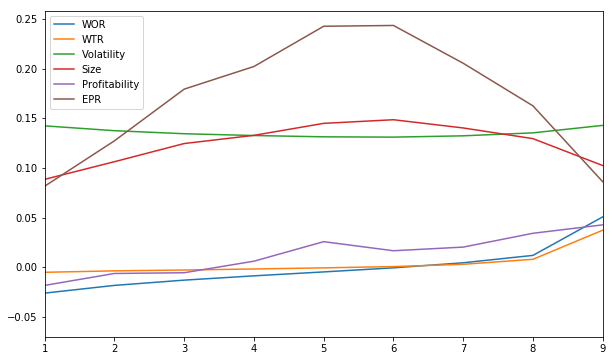

In [26]:
plt.figure(figsize=(10,6))
plt.plot(df_AWOR.WOR,label='WOR')
plt.plot(df_AWOR.WTR,label='WTR')
plt.plot(df_AWOR.Vol,label='Volatility')
plt.plot(df_AWOR.Size/10000000,label='Size')
plt.plot(df_AWOR.Profitability,label='Profitability')
plt.plot(df_AWOR.EPR/1000000000,label='EPR')
plt.legend()
plt.xlim(1,9)
plt.show()

如表格和图片所示， WOR(average weekly over return) 和 WTR(average weekly total return) 均为单调递增。除了在第六组，WOR和WTR收益率符号相反，在其余9组中，符号都相同，且WOR的绝对值都大于WTR，说明出现价格反转。
 <br><br>因为$WOR=\frac{Open-preClose}{preClose}$,$ WTR=\frac{Close-preClose}{preClose}$, $|WOR|>|WTR|\rightarrow |Open-preClose|>|Close-preClose|$，说明开盘价和前一天的收盘价差值较大，然后在当个交易日内会价格会慢慢回落，出现交易日内的价格反转现象。该现象出现的原因是个人投资者倾向于在非正常交易时间段内进行交易，这些交易信息会体现在第二天的开盘价，导致开盘价会过高或过低，之后股票价格会慢慢回归正常值，出现收益率反转。

其余指标，Volatility呈U形，Size和EPR呈倒U形，而profitability没有明显的趋势。WOR最大和最小两组（第0组和第9组）中的股票表现为市值小，股票波动率大，EPR小。


In [27]:
df_total.to_csv('../data/total.csv')